<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TODO" data-toc-modified-id="TODO-1">TODO</a></span></li><li><span><a href="#Relevant-imports" data-toc-modified-id="Relevant-imports-2">Relevant imports</a></span></li><li><span><a href="#Useful-datasets" data-toc-modified-id="Useful-datasets-3">Useful datasets</a></span></li><li><span><a href="#Food-deserts" data-toc-modified-id="Food-deserts-4">Food deserts</a></span><ul class="toc-item"><li><span><a href="#Grocery-stores-density" data-toc-modified-id="Grocery-stores-density-4.1">Grocery stores density</a></span></li><li><span><a href="#Community-areas-by-ethnicity" data-toc-modified-id="Community-areas-by-ethnicity-4.2">Community areas by ethnicity</a></span><ul class="toc-item"><li><span><a href="#Proportion-of-ethnicities-in-the-city-of-Chicago" data-toc-modified-id="Proportion-of-ethnicities-in-the-city-of-Chicago-4.2.1">Proportion of ethnicities in the city of Chicago</a></span></li></ul></li><li><span><a href="#Diet-related-deaths" data-toc-modified-id="Diet-related-deaths-4.3">Diet-related deaths</a></span><ul class="toc-item"><li><span><a href="#Diabetes-related-deaths-(US-baseline-73.1-!)" data-toc-modified-id="Diabetes-related-deaths-(US-baseline-73.1-!)-4.3.1">Diabetes related deaths (US baseline 73.1 !)</a></span></li><li><span><a href="#Colorectal-Cancer-(US-baseline-17)" data-toc-modified-id="Colorectal-Cancer-(US-baseline-17)-4.3.2">Colorectal Cancer (US baseline 17)</a></span></li><li><span><a href="#Stroke-(US-baseline-42.2)" data-toc-modified-id="Stroke-(US-baseline-42.2)-4.3.3">Stroke (US baseline 42.2)</a></span></li></ul></li></ul></li></ul></div>

# TODO
- only keep 'non mixed community areas' (explain ethnic dependency of diseases)
- fit linear regression for each subgroup 
- 

# Relevant imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import datetime

from autocorrect import Speller

from datetime import date as dt

from sklearn.linear_model import LinearRegression

import folium
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd

import geopandas as gpd
from shapely.geometry import shape, Point

import requests
from pandas.io.json import json_normalize
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
from bokeh.layouts import widgetbox, row, column

/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


# Useful datasets

In [2]:
socioeconomic_factors = pd.read_csv("datasets/cleaned_socioeconomic_factors.csv")
inspections = pd.read_csv("datasets/cleaned_inspections.csv")
fp = "datasets/boundaries_processed.geojson"
boundaries_community_areas = gpd.read_file(fp)

In [3]:
socioeconomic_factors.head()

,Community Area,Community Area Name,Colorectal Cancer,Diabetes-related,Stroke (Cerebrovascular Disease),Below Poverty Level,Per Capita Income,Unemployment,Population
0,1,Rogers Park,25.3,77.1,33.7,22.7,23714,7.5,55500
1,2,West Ridge,17.3,60.5,34.7,15.1,21375,7.9,73723
2,3,Uptown,20.5,80.0,41.7,22.7,32355,7.7,56296
3,4,Lincoln Square,8.6,55.4,36.9,9.5,35503,6.8,41483
4,5,North Center,26.1,49.8,41.6,7.1,51615,4.5,34942


In [4]:
boundaries_community_areas.head()

,community,area_number,shape_area,geometry
0,DOUGLAS,35,4.600462e+07,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,36,1.691396e+07,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,37,1.991670e+07,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,38,4.849250e+07,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,39,2.907174e+07,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [5]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Community Area,Violation Numbers,Violation Comments,Reinspections,area_number
0,2345318,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2019-11-08,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,"[3, 5, 58]",[' 2-102.14(O) OBSERVED NO WRITTEN EMPLOYEE H...,1,19
1,2321166,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2019-11-06,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,"[3, 5, 10, 22, 33, 57, 58]",[' OBSERVED NO WRITTEN EMPLOYEE HEALTH POLICY ...,0,19
2,2290717,PAPA JOHN'S PIZZA,PAPA JOHN'S PIZZA,1545897,Restaurant,2,2620 N NARRAGANSETT AVE,2019-05-30,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,"[3, 5]",[' OBSERVED NO EMPLOYEE HEALTH POLICY ON THE P...,0,19
3,2144892,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2018-02-13,Canvass,Pass,NaN,41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,NaN,NaN,1,19
4,2144588,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2018-02-06,Canvass,Fail,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,"[16, 34, 42]",[' OBSERVED BLACK AND PINK MOLD LIKE SUBSTANCE...,0,19


In [6]:
inspections.loc[:,('Inspection Date')]=inspections.loc[:,('Inspection Date')].apply(pd.to_datetime)

In [7]:
inspections.dtypes

Inspection ID                  int64
DBA Name                      object
AKA Name                      object
License #                      int64
Facility Type                 object
Risk                           int64
Address                       object
Inspection Date       datetime64[ns]
Inspection Type               object
Results                       object
Violations                    object
Latitude                     float64
Longitude                    float64
Location                      object
Community Area                object
Violation Numbers             object
Violation Comments            object
Reinspections                  int64
area_number                    int64
dtype: object

# Food deserts

**Context:**

After a small research, we found out about a problem affecting public health in Chicago at a large scale called **Food deserts**. In a report by the Illinois Advisory Committee to the United States Commission on Civil Rights, it is reported that some of the community areas in Chicago are lacking supermarkets, grocery stores and healthy food in general. Restricted access to healthy foods lead to higher rates of chronic illness like diabetes, hypertension, or cardiovascular disease. [source](https://www.usccr.gov/pubs/docs/IL-FoodDeserts-2011.pdf)

Furthermore, it is stated in the report that these food desert neighborhoods are almost exclusively in African American neighborhoods making the issue a civil rights one beyond its public health dimension.

**In the next part we will try to see if we can visualize the food deserts using the food inspection dataset**

**Approach to the problem**

* We first try to look at establishments that represent healthy food providers (grocery store, farmer's market, fish market, meat market, etc). These establishments also have inspections and so we retrieve them from our dataset and plot their intensity by 1'000 habitants for the different community areas.

* We then try to visualize on a map the most common ethnicity accross all community areas as well as some socio economic factors.

* In the end we will show diet related disease rates by community area as well and try to see how it relates.

## Grocery stores density

In [8]:
#We care about grocery stores only
groceries_intensity = inspections[inspections['Facility Type']=='Market']
# We take distinct markets ranging from year 2015 to 2019
# This is because some establishment do not receive any inspection on a given year sometimes 
groceries_intensity = groceries_intensity[groceries_intensity['Inspection Date'].dt.year==2018]
groceries_intensity = groceries_intensity[['Community Area','DBA Name','area_number']].drop_duplicates().groupby(['Community Area','area_number'])['DBA Name'].agg({'nbr_markets' : len})
groceries_intensity.reset_index(inplace=True)
groceries_intensity.head(1)

,Community Area,area_number,nbr_markets
0,ALBANY PARK,14,25


We tried to compute intensity of markets by 10'000 habitant but it was not representative at all.
Because even if some areas are more dense in population the distribution of healthy food should be equal in terms of surface which is the essence of the problem as described in the [wikipedia page]    (https://en.wikipedia.org/wiki/Supermarket_shortage) which leads people to take long distance rides to have access to fresh food and furthermore the public transportation system is usually also bad for those areas.
We hence plot the density of markets by surface.

In [9]:
population_by_community = socioeconomic_factors[['Community Area','Population']]
groceries_intensity = groceries_intensity.merge(population_by_community,\
                              left_on='area_number', right_on='Community Area')

groceries_intensity = groceries_intensity.merge(boundaries_community_areas,\
                              left_on='area_number', right_on='area_number')



groceries_intensity['markets_by_surface'] = groceries_intensity['nbr_markets'].div(groceries_intensity['shape_area'].values,axis=0)
min_value, max_value = np.min(groceries_intensity['markets_by_surface']), np.max(groceries_intensity['markets_by_surface'])

groceries_intensity['markets_by_surface']=(groceries_intensity['markets_by_surface']-min_value)/max_value

groceries_intensity.drop(columns=['Community Area_y', 'community'], inplace=True)
groceries_intensity.rename(columns={'Community Area_x':'Community Area'}, inplace=True)

groceries_intensity.head()

,Community Area,area_number,nbr_markets,Population,shape_area,geometry,markets_by_surface
0,ALBANY PARK,14,25,51575,5.354223e+07,"MULTIPOLYGON (((-87.70404 41.97355, -87.70403 ...",0.654319
1,ARCHER HEIGHTS,57,1,13259,5.592251e+07,"MULTIPOLYGON (((-87.71437 41.82604, -87.71436 ...",0.006035
2,ARMOUR SQUARE,34,11,13635,2.776620e+07,"MULTIPOLYGON (((-87.62917 41.84556, -87.62947 ...",0.552168
3,ASHBURN,70,4,43283,1.354603e+08,"MULTIPOLYGON (((-87.71255 41.75734, -87.71252 ...",0.022850
4,AUBURN GRESHAM,71,23,45770,1.050654e+08,"MULTIPOLYGON (((-87.63990 41.75615, -87.63990 ...",0.296264


In [10]:
# Initialize the map:
groceries_by_community = folium.Map([41.84, -87.7099], zoom_start=10.5, tiles = "cartodbpositron")
         
# Add the color for the chloropleth:
groceries_by_community.choropleth(
     geo_data=fp,
     name='Grocery Stores Density',
     data=groceries_intensity,
     columns=['Community Area', 'markets_by_surface'],
     key_on='feature.properties.community',
     fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.3,
     legend_name='Grocery Stores Density',
     highlight=True,
)   

# This is used to be able to render the tooltip -> folium is not really flexible in that sense
x = boundaries_community_areas.merge(groceries_intensity,\
                              left_on=['area_number','community','geometry','shape_area'], \
                                     right_on=['area_number','Community Area','geometry','shape_area'])
x['Population']=(np.round(x['Population']/1000)).astype(int)

folium.GeoJson(
    x,
    name='community',
    show=True,
    style_function=lambda x: {
        'fillColor': 'black',
        'color': 'black',
        'weight': 0.3,
        'fillOpacity':0
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community', 'nbr_markets','Population'],
        aliases=['Community Area', 'Number of Grocery Stores','Population Count (in thousands)'],
    ),
).add_to(groceries_by_community)

# Save to html
groceries_by_community.save('./groceries_by_community.html')

"Chicago’s segregation is certainly legendary, with the North and South sides divided by class and race. To keep it stereotypically simple: The North Side is white, the South Side is black." [source](https://chicago.eater.com/2018/12/13/18138387/chicago-magazine-john-kessler-food-scene-racism-immigration-food)

We certainly see a difference in the concentration of grocery stores between the North and the South, the south being quite sparse.


## Community areas by ethnicity

https://www.chicagohealthatlas.org/indicators/non-hispanic-white

In [11]:
latino = pd.read_excel('datasets/Hispanic_or_Latino_population.xlsx')
black = pd.read_excel('datasets/Non-Hispanic_African-Amercian_or_Black_population.xlsx')
asian = pd.read_excel('datasets/Non-Hispanic_Asian_or_Pacific_Islander_population.xlsx')
white = pd.read_excel('datasets/Non-Hispanic_White_population.xlsx')

In [12]:
black.shape

(249, 27)

In [13]:
white.columns

Index(['Category', 'SubCategory', 'Indicator', 'Year', 'Geography',
       'Geo_Group', 'Geo_ID', 'Demography', 'Demo_Group', 'Number',
       'Cum_Number', 'Ave_Annual_Number', 'Crude_Rate',
       'Lower_95CI_Crude_Rate', 'Upper_95CI_Crude_Rate', 'Age_Adj_Rate',
       'Lower_95CI_Age_Adj_Rate', 'Upper_95CI_Age_Adj_Rate', 'Percent',
       'Lower_95CI_Percent', 'Upper_95CI_Percent', 'Weight_Number',
       'Weight_Percent', 'Lower_95CI_Weight_Percent',
       'Upper_95CI_Weight_Percent', 'Map_Key', 'Flag'],
      dtype='object')

In [14]:
def preprocess_ethnicity(df):
    df = df\
                        .drop(columns =['Category', 'SubCategory', 'Geo_ID', 'Demography', 'Demo_Group', 
                                        'Cum_Number', 'Ave_Annual_Number', 'Crude_Rate', 'Lower_95CI_Crude_Rate', 
                                        'Upper_95CI_Crude_Rate', 'Age_Adj_Rate', 'Lower_95CI_Age_Adj_Rate', 
                                        'Upper_95CI_Age_Adj_Rate', 'Percent', 'Lower_95CI_Percent', 'Indicator',
                                        'Upper_95CI_Percent', 'Weight_Number', 'Weight_Percent', 'Geography',
                                        'Lower_95CI_Weight_Percent','Upper_95CI_Weight_Percent', 'Map_Key', 'Flag'])
    df = df[df['Year']=='2012-2016'].reset_index()
    df = df.drop(columns='index')
    df['Community Area'] = [df.Geo_Group[i].split('-', 1)[0] for i in range(len(df))] 
    df['Community Area Name'] = [df.Geo_Group[i].split('-', 1)[1] for i in range(len(df))] 
    df = df.drop(columns=['Geo_Group','Year'])
    df = df[['Community Area', 'Community Area Name', 'Number']]
    df['Community Area'] = df['Community Area'].astype(int)
    return df

In [15]:
latino = preprocess_ethnicity(latino)
black = preprocess_ethnicity(black)
asian = preprocess_ethnicity(asian)
white = preprocess_ethnicity(white)[:77]

In [16]:
white.rename(columns={'Number':'Number_White'}, inplace=True)
latino.rename(columns={'Number':'Number_Latino'}, inplace=True)
black.rename(columns={'Number':'Number_Black'}, inplace=True)
asian.rename(columns={'Number':'Number_Asian'}, inplace=True)

In [17]:
ethnicity_by_community = white
ethnicity_by_community['Number_Latino'] = latino['Number_Latino']
ethnicity_by_community['Number_Black'] = black['Number_Black']
ethnicity_by_community['Number_Asian'] = asian['Number_Asian']
ethnicity_by_community

,Community Area,Community Area Name,Number_White,Number_Latino,Number_Black,Number_Asian
0,1,Rogers Park,23604,12383,14455,3205
1,2,West Ridge,31806,13366,8936,16641
2,3,Uptown,30456,7468,10970,5803
3,4,Lincoln Square,26554,7284,1394,4608
4,5,North Center,26996,4378,713,1563
...,...,...,...,...,...,...
72,73,Washington Heights,170,324,25981,8
73,74,Mount Greenwood,15730,2090,589,368
74,75,Morgan Park,9689,2414,16083,110
75,76,O'Hare,14742,3939,396,1995


In [18]:
ethnicity_by_community.to_csv("datasets/ethnicity_by_community.csv",index=False)

### Proportion of ethnicities in the city of Chicago

In [19]:
sum_ethnicity = list(ethnicity_by_community.sum(axis=0)[['Number_White','Number_Latino','Number_Black','Number_Asian']])
sum_ethnicity

[890639, 795440, 833779, 164871]

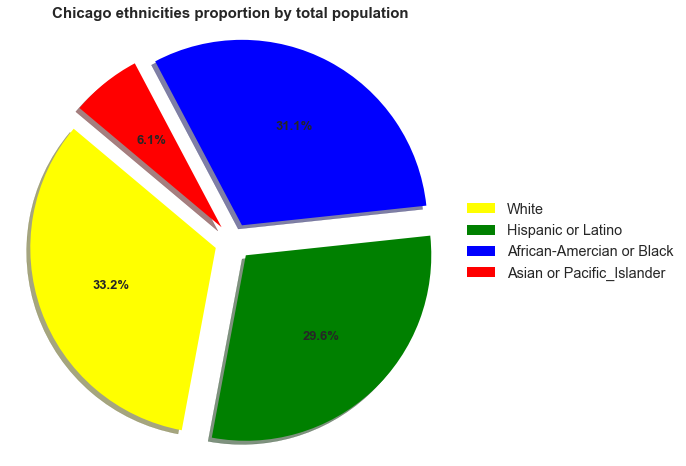

In [20]:
# Data to plot

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

labels = 'White', 'Hispanic or Latino', 'African-Amercian or Black', 'Asian or Pacific_Islander'
sizes = sum_ethnicity
colors = ['yellow','green','blue','red']
explode = (0.1, 0.1, 0.1, 0.1)  # explode 1st slice

# Plot
wedges, texts, autotexts = plt.pie(sizes, explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.setp(autotexts, size=13, weight="bold")

plt.setp(texts, size=13, weight="bold")

ax.legend(wedges, labels,
          #title="Ethnicities",
          loc="center left",
          fontsize = 'x-large',
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title("Chicago ethnicities proportion by total population", size=15, weight="bold")

plt.axis('equal')
plt.show()

In [21]:
ethnicity_by_community['Population'] = ethnicity_by_community[['Number_White','Number_Latino','Number_Black','Number_Asian']].sum(axis=1)
ethnicity_by_community

,Community Area,Community Area Name,Number_White,Number_Latino,Number_Black,Number_Asian,Population
0,1,Rogers Park,23604,12383,14455,3205,53647
1,2,West Ridge,31806,13366,8936,16641,70749
2,3,Uptown,30456,7468,10970,5803,54697
3,4,Lincoln Square,26554,7284,1394,4608,39840
4,5,North Center,26996,4378,713,1563,33650
...,...,...,...,...,...,...,...
72,73,Washington Heights,170,324,25981,8,26483
73,74,Mount Greenwood,15730,2090,589,368,18777
74,75,Morgan Park,9689,2414,16083,110,28296
75,76,O'Hare,14742,3939,396,1995,21072


In [22]:
majority = np.argmax(np.array(ethnicity_by_community[['Number_White','Number_Latino','Number_Black','Number_Asian']]),axis=1)

In [23]:
ethnicity_by_community['Majority'] = majority
#ethnicity_by_community.replace({'Majority': {0 : 'White', 1 : 'Latino', 2 : 'Black', 3 : 'Asian'}},inplace=True)
ethnicity_by_community['proportion_white']=np.round(ethnicity_by_community['Number_White'].div(ethnicity_by_community['Population'].values,axis=0)*100).astype('int')
ethnicity_by_community['proportion_black']=np.round(ethnicity_by_community['Number_Black'].div(ethnicity_by_community['Population'].values,axis=0)*100).astype('int')
ethnicity_by_community['proportion_asian']=np.round(ethnicity_by_community['Number_Asian'].div(ethnicity_by_community['Population'].values,axis=0)*100).astype('int')
ethnicity_by_community['proportion_latino']=np.round(ethnicity_by_community['Number_Latino'].div(ethnicity_by_community['Population'].values,axis=0)*100).astype('int')
ethnicity_by_community

,Community Area,Community Area Name,Number_White,Number_Latino,Number_Black,Number_Asian,Population,Majority,proportion_white,proportion_black,proportion_asian,proportion_latino
0,1,Rogers Park,23604,12383,14455,3205,53647,0,44,27,6,23
1,2,West Ridge,31806,13366,8936,16641,70749,0,45,13,24,19
2,3,Uptown,30456,7468,10970,5803,54697,0,56,20,11,14
3,4,Lincoln Square,26554,7284,1394,4608,39840,0,67,3,12,18
4,5,North Center,26996,4378,713,1563,33650,0,80,2,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Washington Heights,170,324,25981,8,26483,2,1,98,0,1
73,74,Mount Greenwood,15730,2090,589,368,18777,0,84,3,2,11
74,75,Morgan Park,9689,2414,16083,110,28296,2,34,57,0,9
75,76,O'Hare,14742,3939,396,1995,21072,0,70,2,9,19


In [24]:
# Initialize the map:
ethnicity_map = folium.Map([41.84, -87.7099], zoom_start=10.5, tiles = "cartodbpositron")
         
x = boundaries_community_areas.merge(ethnicity_by_community,\
                              left_on=['area_number'], \
                                     right_on=['Community Area'])

folium.GeoJson(
    x,
    style_function=lambda feature: {
        'fillColor': 'yellow' if feature['properties']['Majority'] ==0 \
                                else 'green' if feature['properties']['Majority'] ==1\
                                else 'blue' if feature['properties']['Majority'] ==2\
                                else 'red',
        'fillOpacity':0.5,
        'color': 'black',
        'weight': 0.4
        #'dashArray': '5, 5'
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community','proportion_black','proportion_white','proportion_asian','proportion_latino'],
        aliases=['Community Area','Percentage of Black','Percentage of White','Percentage of Asians','Percentage of Latinos'],
    ),
).add_to(ethnicity_map)


# Save to html
ethnicity_map.save('./ethnicity_map.html')


## Diet-related deaths

In [33]:
groceries_intensity

,Community Area,area_number,nbr_markets,Population,shape_area,geometry,markets_by_surface
0,ALBANY PARK,14,25,51575,5.354223e+07,"MULTIPOLYGON (((-87.70404 41.97355, -87.70403 ...",0.654319
1,ARCHER HEIGHTS,57,1,13259,5.592251e+07,"MULTIPOLYGON (((-87.71437 41.82604, -87.71436 ...",0.006035
2,ARMOUR SQUARE,34,11,13635,2.776620e+07,"MULTIPOLYGON (((-87.62917 41.84556, -87.62947 ...",0.552168
3,ASHBURN,70,4,43283,1.354603e+08,"MULTIPOLYGON (((-87.71255 41.75734, -87.71252 ...",0.022850
4,AUBURN GRESHAM,71,23,45770,1.050654e+08,"MULTIPOLYGON (((-87.63990 41.75615, -87.63990 ...",0.296264
...,...,...,...,...,...,...,...
72,WEST LAWN,65,10,33595,8.231530e+07,"MULTIPOLYGON (((-87.71255 41.75734, -87.71278 ...",0.155607
73,WEST PULLMAN,53,9,30793,9.936520e+07,"MULTIPOLYGON (((-87.61828 41.65911, -87.61829 ...",0.110983
74,WEST RIDGE,2,32,73723,9.842909e+07,"MULTIPOLYGON (((-87.68465 42.01948, -87.68464 ...",0.449580
75,WEST TOWN,24,31,84458,1.275629e+08,"MULTIPOLYGON (((-87.65686 41.91078, -87.65685 ...",0.331066


### Diabetes related deaths (US baseline 73.1 !)

(77,)

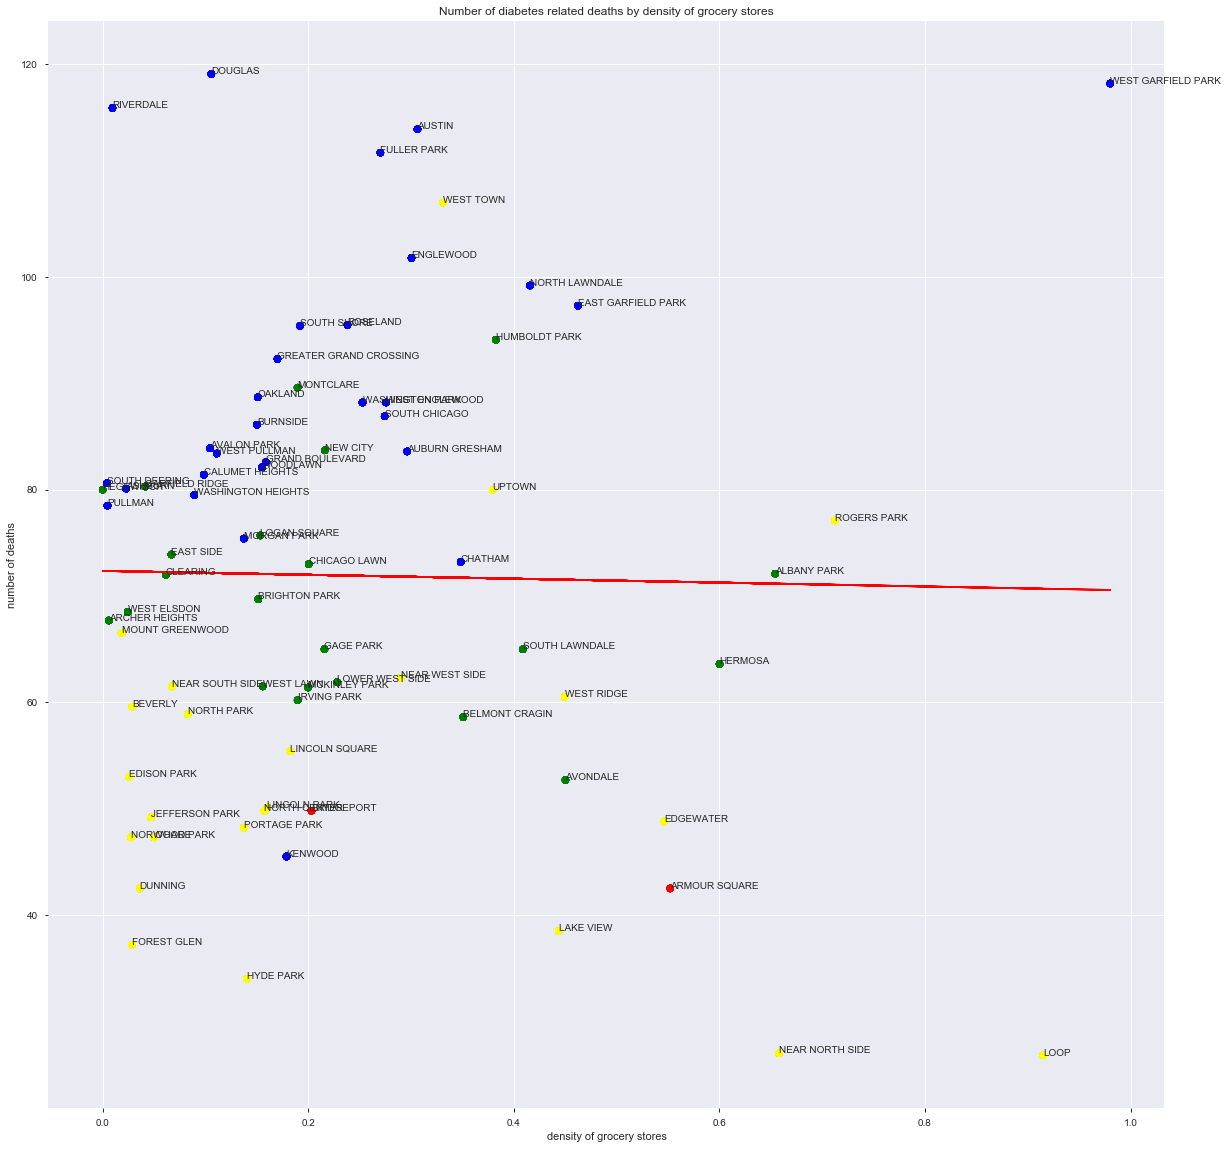

In [56]:
fig, ax = plt.subplots(figsize=(20,20))
colors = np.array(ethnicity_by_community.sort_values(by='Community Area', ascending=True)['Majority'].replace({0 : 'yellow', 1 : 'green', 2 : 'blue', 3 : 'red'}))
ys = np.array(socioeconomic_factors.sort_values(by='Community Area', ascending=True)['Diabetes-related'])
xs = np.array(groceries_intensity.sort_values(by='area_number', ascending=True)['markets_by_surface'])
labels = np.array(groceries_intensity.sort_values(by='area_number', ascending=True)['Community Area'])
plt.title('Number of diabetes related deaths by density of grocery stores')
plt.xlabel('density of grocery stores')
plt.ylabel('number of deaths')
i=0

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(xs.reshape(-1,1), ys.reshape(-1,1))  # perform linear regression
Y_pred = linear_regressor.predict(xs.reshape(-1,1))  # make predictions

for x, y, c in zip(xs,ys,colors):
    ax.scatter(xs, ys, color=colors)
    ax.annotate(labels[i], (x, y))
    i+=1
    
plt.plot(xs, Y_pred, color='red')
labels.shape

In [30]:
socioeconomic_factors.head()

,Community Area,Community Area Name,Colorectal Cancer,Diabetes-related,Stroke (Cerebrovascular Disease),Below Poverty Level,Per Capita Income,Unemployment,Population
0,1,Rogers Park,25.3,77.1,33.7,22.7,23714,7.5,55500
1,2,West Ridge,17.3,60.5,34.7,15.1,21375,7.9,73723
2,3,Uptown,20.5,80.0,41.7,22.7,32355,7.7,56296
3,4,Lincoln Square,8.6,55.4,36.9,9.5,35503,6.8,41483
4,5,North Center,26.1,49.8,41.6,7.1,51615,4.5,34942


In [31]:
# Initialize the map:
diabetes_map = folium.Map([41.84, -87.7099], zoom_start=10.5)
         
# Add the color for the chloropleth:
diabetes_map.choropleth(
     geo_data=fp,
     name='Diabetes_related_mortality',
     data=socioeconomic_factors,
     columns=['Community Area', 'Diabetes-related'],
     key_on='feature.properties.area_number',
     fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.3,
     legend_name='Diabetes related mortality per 100,000 persons',
     highlight=True,
)   

# This is used to be able to render the tooltip -> folium is not really flexible in that sense
x = boundaries_community_areas.merge(socioeconomic_factors,\
                              left_on=['area_number'], \
                                     right_on=['Community Area'])

folium.GeoJson(
    x,
    name='community',
    show=True,
    style_function=lambda x: {
        'fillColor': 'red',
        'color': 'black',
        'weight': 1,
        'fillOpacity':0
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community','Diabetes-related'],
        aliases=['Community Area','Number of Diabetes related deaths'],
    ),
).add_to(diabetes_map)

# Save to html
diabetes_map.save('./diabetes_mortality.html')

### Colorectal Cancer (US baseline 17)

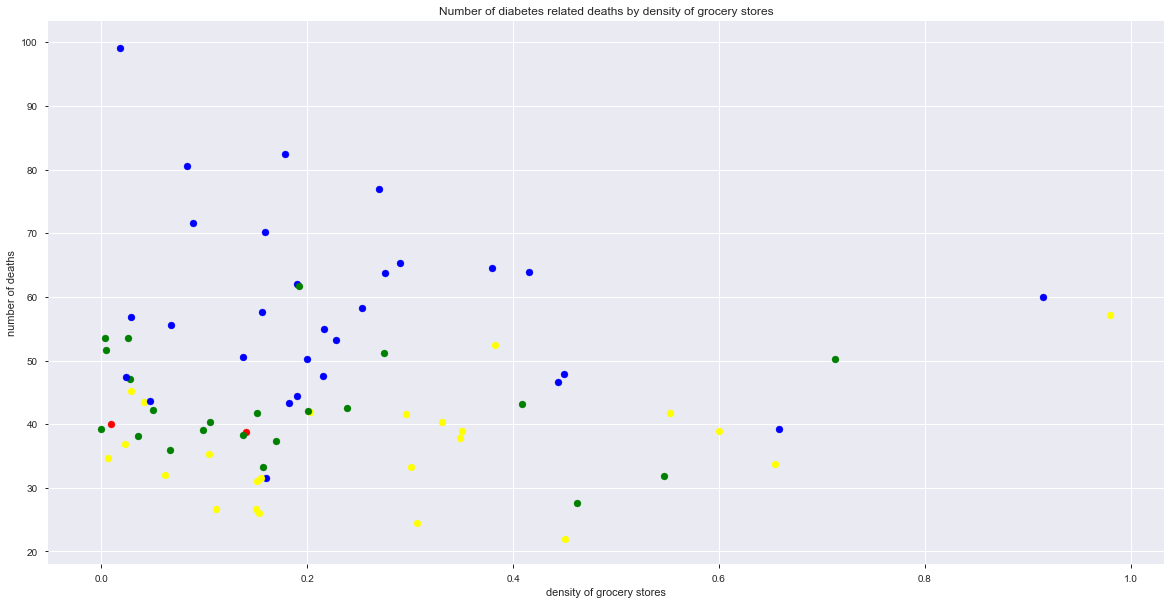

In [105]:
plt.figure(figsize=(20,10))
colors = ethnicity_by_community['Majority'].replace({0 : 'yellow', 1 : 'green', 2 : 'blue', 3 : 'red'})
ys = socioeconomic_factors['Stroke (Cerebrovascular Disease)']
xs = groceries_intensity['markets_by_surface']
plt.title('Number of diabetes related deaths by density of grocery stores')
plt.xlabel('density of grocery stores')
plt.ylabel('number of deaths')
for x, y, c in zip(xs,ys,colors):
    plt.scatter(x, y, color=c)

In [32]:
# Initialize the map:
colorectal_map = folium.Map([41.84, -87.7099], zoom_start=10.5)
         
# Add the color for the chloropleth:
colorectal_map.choropleth(
     geo_data=fp,
     name='colorectal_cancer_related_mortality',
     data=socioeconomic_factors,
     columns=['Community Area', 'Colorectal Cancer'],
     key_on='feature.properties.area_number',
     fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.3,
     legend_name='Colorectal cancer related mortality per 100,000 persons',
     highlight=True,
)   

# This is used to be able to render the tooltip -> folium is not really flexible in that sense
x = boundaries_community_areas.merge(socioeconomic_factors,\
                              left_on=['area_number'], \
                                     right_on=['Community Area'])

folium.GeoJson(
    x,
    name='community',
    show=True,
    style_function=lambda x: {
        'fillColor': 'red',
        'color': 'black',
        'weight': 1,
        'fillOpacity':0
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community','Colorectal Cancer'],
        aliases=['Community Area','Number of Colorectal Cancer related deaths'],
    ),
).add_to(colorectal_map)

# Save to html
colorectal_map.save('./colorectal_map.html')

### Stroke (US baseline 42.2)

In [33]:
# Initialize the map:
stroke_map = folium.Map([41.84, -87.7099], zoom_start=10.5)
         
# Add the color for the chloropleth:
stroke_map.choropleth(
     geo_data=fp,
     name='stroke_mortality',
     data=socioeconomic_factors,
     columns=['Community Area', 'Stroke (Cerebrovascular Disease)'],
     key_on='feature.properties.area_number',
     fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
     legend_name='Stroke mortality per 100,000 persons',
     highlight=True,
)   

# This is used to be able to render the tooltip -> folium is not really flexible in that sense
x = boundaries_community_areas.merge(socioeconomic_factors,\
                              left_on=['area_number'], \
                                     right_on=['Community Area'])

folium.GeoJson(
    x,
    name='community',
    show=True,
    style_function=lambda x: {
        'fillColor': 'black',
        'color': 'black',
        'weight': 1,
        'fillOpacity':0
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community','Stroke (Cerebrovascular Disease)'],
        aliases=['Community Area','Deaths by stroke'],
    ),
).add_to(stroke_map)

# Save to html
stroke_map.save('./stroke_map.html')
